In [1]:
import os
os.chdir("../")

In [2]:

import json
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import numpy as np
from robust_dst.scoring_utils import flatten_metrics_dict

In [3]:
EXPERIMENT="seed_420_replicate_sdt"
LARGE="_large"

In [4]:
v0 = f"metrics/{EXPERIMENT}_v0{LARGE}/original/dev/version_1"
v1 = f"metrics/{EXPERIMENT}_v1{LARGE}/original/dev/version_1"
v2 = f"metrics/{EXPERIMENT}_v2{LARGE}/original/dev/version_1"
v3 = f"metrics/{EXPERIMENT}_v3{LARGE}/original/dev/version_1"
v4 = f"metrics/{EXPERIMENT}_v4{LARGE}/original/dev/version_1"


In [5]:
import matplotlib.pyplot as plt

class Plotter:
    JSON_KEYS = {
        "JGA": "#ALL_SERVICES/joint_goal_accuracy",
        "JGA_seen": "#SEEN_SERVICES/joint_goal_accuracy",
        "JGA_unseen": "#UNSEEN_SERVICES/joint_goal_accuracy",
        "JGA_cat": "#ALL_SERVICES/joint_cat_accuracy",
        "JGA_seen_cat": "#SEEN_SERVICES/joint_cat_accuracy",
        "JGA_unseen_cat": "#UNSEEN_SERVICES/joint_cat_accuracy",
        "JGA_non_cat": "#ALL_SERVICES/joint_noncat_accuracy",
        "JGA_seen_non_cat": "#SEEN_SERVICES/joint_noncat_accuracy",
        "JGA_unseen_non_cat": "#UNSEEN_SERVICES/joint_noncat_accuracy"
    }

    def __init__(self, jgas, ckpts):
        self.jgas = jgas  # Dictionary containing metric values
        self.ckpts = ckpts  # List of checkpoint steps

    def plot_metrics(self, flattened_axs, label):
        """Plots each metric on a separate subplot with LaTeX labels."""
        for i, metric in enumerate(self.jgas):
            flattened_axs[i].plot(self.ckpts, self.jgas[metric], label=label)
            flattened_axs[i].set_title(rf"{metric}")  # LaTeX format
            flattened_axs[i].legend()
            flattened_axs[i].set_xlabel("Global step")
            flattened_axs[i].set_xticks(range(min(self.ckpts), max(self.ckpts) + 1, 10000))
            flattened_axs[i].set_xticklabels([f"{x//1000}k" for x in range(min(self.ckpts), max(self.ckpts) + 1, 10000)])

        plt.tight_layout()
        plt.savefig("metrics_separate.pdf")  # Save plots as PDF

    def plot_same_graph(self, label, title_fontsize=14, tick_fontsize=12, axes_label_fontsize=20, legend_fontsize=10, metrics: list[str] = None, ticks_step=3200, bbox=(1.0, 0.0), ncol=3):
        """Plots all metrics on the same graph with customizable font sizes."""
        plt.figure(figsize=(10, 6))
        line_styles = ['-', '--', ':', '-.']
        for i, metric in enumerate(self.jgas):
            if metrics is not None and metric not in metrics:
                continue
            plt.plot(
                self.ckpts, 
                self.jgas[metric], 
                linestyle=line_styles[i % len(line_styles)],  # Cycle through line styles
                linewidth=2,  # Make lines thicker for clarity
                label=rf"$\mathrm{{JGA}}_{{\mathrm{{{metric.split('_', 1)[1]}}}}}$" if "_" in metric else rf"$\mathrm{{{metric}}}$"
            )
            
        
        plt.xlabel("Global step", fontsize=axes_label_fontsize)
        plt.ylabel("Accuracy", fontsize=axes_label_fontsize)
        # plt.title(r"Joint Goal Accuracy Metrics Over Steps", fontsize=title_fontsize)
        plt.legend(fontsize=legend_fontsize, ncol=ncol, bbox_to_anchor=bbox)
        plt.tick_params(axis='y', labelsize=tick_fontsize)


        # Set x-ticks to range from min to max, with a step of 1000, and format labels as 1k, 2k, etc.
        
        plt.xticks(range(min(self.ckpts), max(self.ckpts) + 1, ticks_step),
                   [f"{x/1000:.1f}k" for x in range(min(self.ckpts), max(self.ckpts) + 1, ticks_step)])
        plt.tick_params(axis='x', labelsize=tick_fontsize, rotation=45)
        plt.axvline(x=10986, color='black', linestyle='--', linewidth=1.5, label="Epoch Mark")

        plt.tight_layout()
        plt.savefig("sdt_behaviour.pdf")  # Save plot as PDF


        
class Metrics(Plotter):
    def __init__(self, metrics_folder):
        self.metrics_folder = metrics_folder
        self.jgas = {item: [] for item in self.JSON_KEYS.keys()}
        self.ckpts = []
        self.process()

    def process(self):
        files = os.listdir(self.metrics_folder)
        files.sort(key=lambda x: int(x.split("_")[1].split(".")[0]))
        for file in files[:-1]:  # Skipping the last file, assuming it's not needed
            ckpt = int(file.split("_")[1].split(".")[0])
            file_path = os.path.join(self.metrics_folder, file)
            with open(file_path, "r") as f:
                results = json.load(f)
            
            self.ckpts.append(ckpt)
            for metric in self.JSON_KEYS:
                # Multiply by 100 and round to two decimal places
                metric_value = results[self.JSON_KEYS[metric]] * 100
                metric_value = round(metric_value, 2)  # Round to two decimal places
                self.jgas[metric].append(metric_value)


class FastInference(Plotter):
    def __init__(self, main_folder, constraints):
        self.main_folder = main_folder
        self.constraints = constraints
        self.jgas = {item: [] for item in self.JSON_KEYS.keys()}
        self.ckpts = []
        self.process()
        
    def process(self):
        folders = os.listdir(self.main_folder)
        folders.sort(key=lambda x: int(x.split("-")[-1]))
        for folder in folders:
            ckpt = int(folder.split("-")[-1])
            path = os.path.join(self.main_folder, folder)
            path = os.path.join(path, self.constraints)
            path = os.path.join(path, "metrics.json")
            if os.path.exists(path):
                with open(path, "r") as f:
                    results = json.load(f)
                self.ckpts.append(ckpt)
                for metric in self.JSON_KEYS:
                    self.jgas[metric].append(results[self.JSON_KEYS[metric]])




In [6]:
v0_metrics = Metrics(v0)
v1_metrics = Metrics(v1)
v2_metrics = Metrics(v2)
v3_metrics = Metrics(v3)
# v4_metrics = Metrics(v4)

In [7]:
v0_metrics.jgas["JGA"]

[90.11,
 91.22,
 92.31,
 92.2,
 91.64,
 90.72,
 92.29,
 92.21,
 90.72,
 90.43,
 89.58,
 90.78,
 90.45]

In [8]:
print("JGA Maxima")
v0_max = np.argmax(v0_metrics.jgas["JGA"])
v1_max = np.argmax(v1_metrics.jgas["JGA"])
v2_max = np.argmax(v2_metrics.jgas["JGA"])
v3_max = np.argmax(v3_metrics.jgas["JGA"])
# v4_max = np.argmax(v4_metrics.jgas["JGA"])
print(v0_max, v0_metrics.ckpts[v0_max])
print(v1_max, v1_metrics.ckpts[v1_max])
print(v2_max, v2_metrics.ckpts[v2_max])
print(v3_max, v3_metrics.ckpts[v3_max])
# print(v4_max, v4_metrics.ckpts[v4_max])

print("JGA Unseen Maxima")
v0_max = np.argmax(v0_metrics.jgas["JGA_unseen"])
v1_max = np.argmax(v1_metrics.jgas["JGA_unseen"])
v2_max = np.argmax(v2_metrics.jgas["JGA_unseen"])
v3_max = np.argmax(v3_metrics.jgas["JGA_unseen"])
# v4_max = np.argmax(v4_metrics.jgas["JGA_unseen"])
print(v0_max, v0_metrics.ckpts[v0_max])
print(v1_max, v1_metrics.ckpts[v1_max])
print(v2_max, v2_metrics.ckpts[v2_max])
print(v3_max, v3_metrics.ckpts[v3_max])
# print(v4_max, v4_metrics.ckpts[v4_max])

JGA Maxima
2 4800
2 4800
1 3200
8 14400
JGA Unseen Maxima
2 4800
2 4800
1 3200
3 6400


In [9]:
v3_metrics.jgas["JGA"]

[90.11,
 91.21,
 90.82,
 92.59,
 91.27,
 91.17,
 91.74,
 92.13,
 92.68,
 91.76,
 90.27,
 90.8,
 90.47,
 90.64,
 91.0,
 91.19]

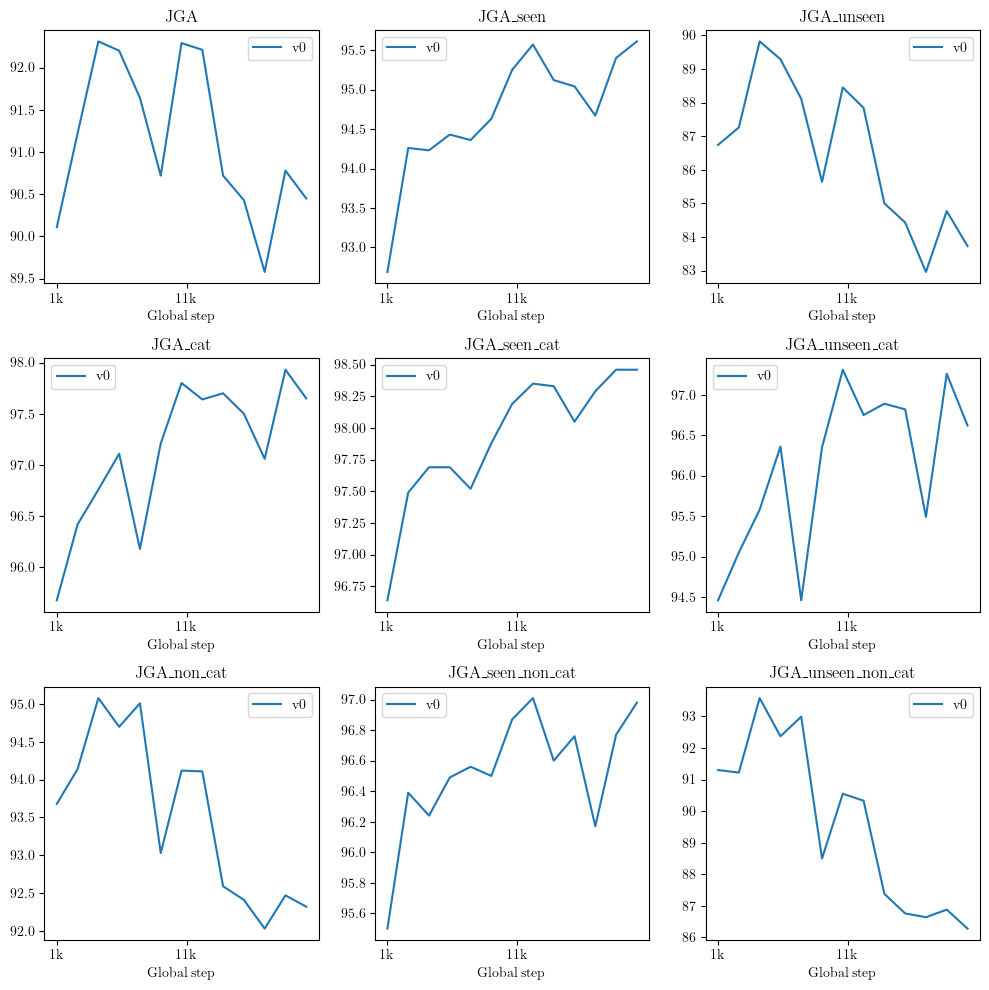

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
v0_metrics.plot_metrics(ax.flatten(), "v0")
# v1_metrics.plot_metrics(ax.flatten(), "v1")
# v2_metrics.plot_metrics(ax.flatten(), "v2")
# v3_metrics.plot_metrics(ax.flatten(), "v3")
# v4_metrics.plot_metrics(ax.flatten(), "v4")
fig.tight_layout()
plt.show()

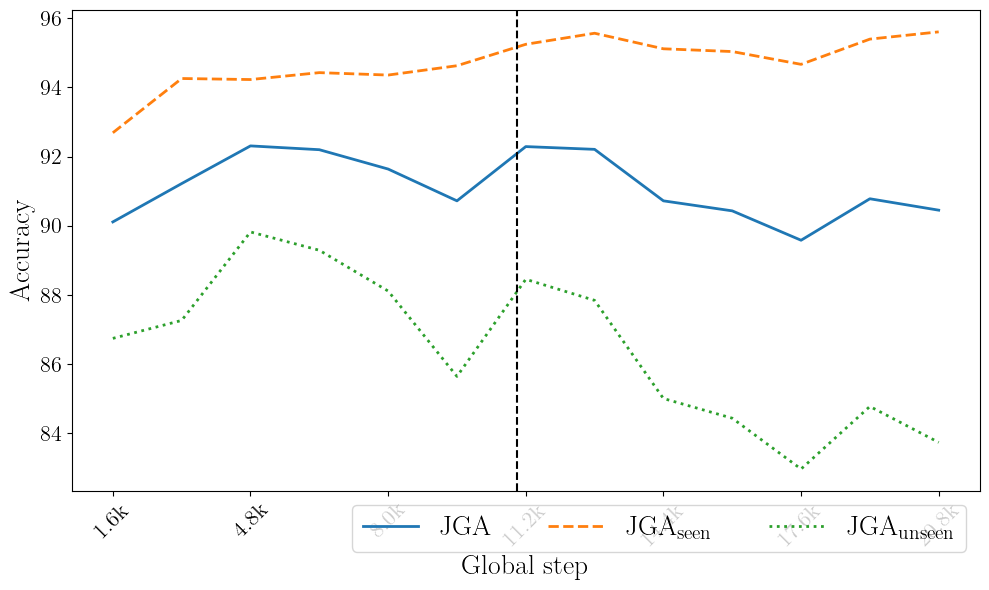

In [11]:
v0_metrics.plot_same_graph("v0", metrics=["JGA", "JGA_seen",  "JGA_unseen"], legend_fontsize=20, tick_fontsize=16)

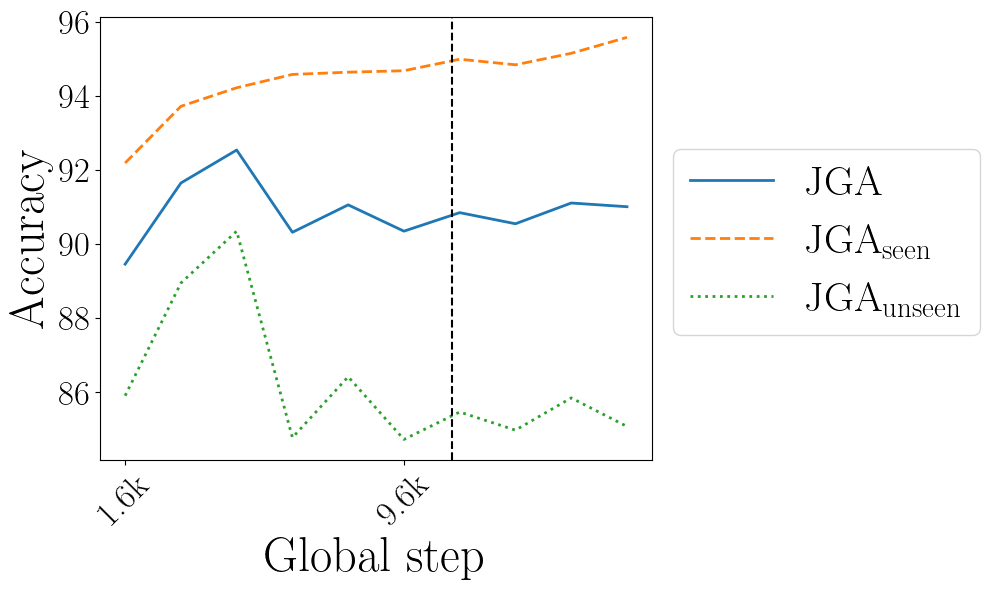

In [12]:
v1_metrics.plot_same_graph(
    "v1", 
    metrics=["JGA", "JGA_seen",  "JGA_unseen"], 
    legend_fontsize=30, 
    tick_fontsize=25, 
    axes_label_fontsize=35, 
    ticks_step=8000,
    bbox=(1.0, 0.75),
    ncol=1,
)

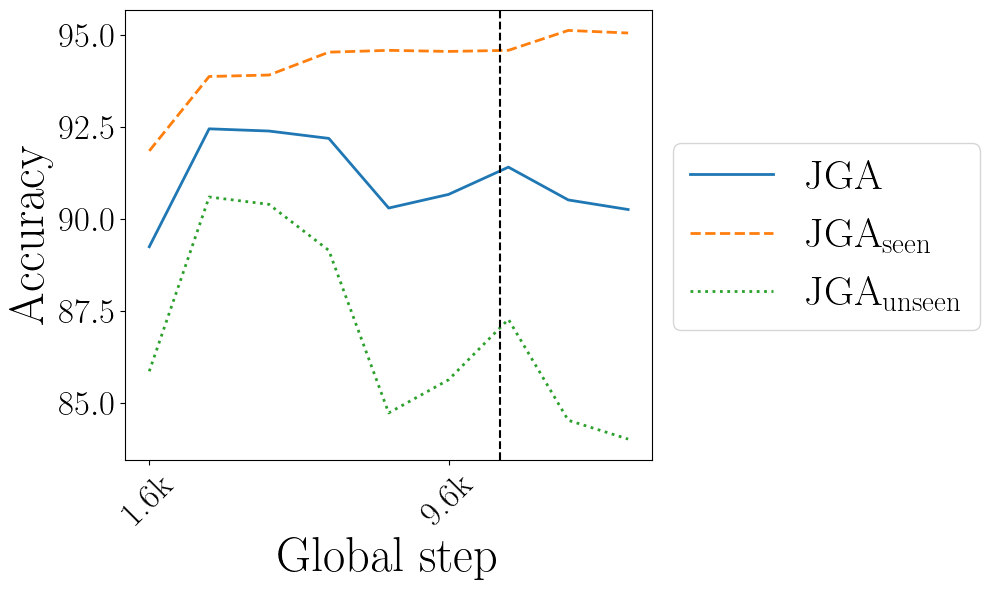

In [13]:
v2_metrics.plot_same_graph(
    "v1", 
    metrics=["JGA", "JGA_seen",  "JGA_unseen"], 
    legend_fontsize=30, 
    tick_fontsize=25, 
    axes_label_fontsize=35, 
    ticks_step=8000,
    bbox=(1.0, 0.75),
    ncol=1,
)

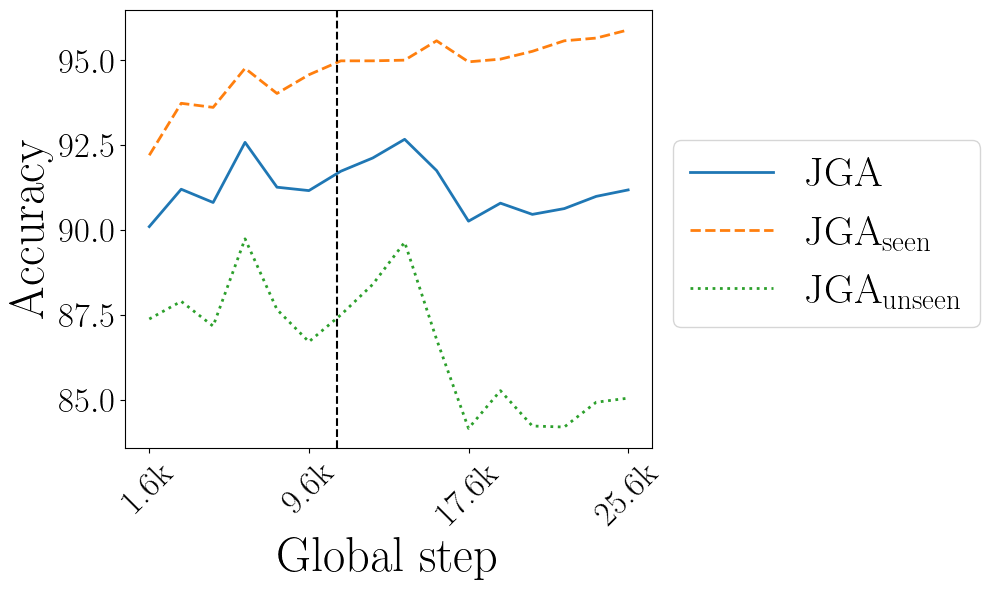

In [14]:
v3_metrics.plot_same_graph(
    "v1", 
    metrics=["JGA", "JGA_seen",  "JGA_unseen"], 
    legend_fontsize=30, 
    tick_fontsize=25, 
    axes_label_fontsize=35, 
    ticks_step=8000,
    bbox=(1.0, 0.75),
    ncol=1,
)